## iPyLeaflet
[ipyleaflet](https://github.com/ellisonbg/ipyleaflet) is a bridge between jupyter notebooks and the [leaflet](http://leafletjs.com/)  javascript library for drawing maps.

ipyleaflet comes with a few examples notebooks (this notebook was derived from one) but very little documentation,
for more documentation read the [Leaflet IPA](http://leafletjs.com/reference.html)

For installation directions, see the README on [ipyleaflet](https://github.com/ellisonbg/ipyleaflet)

In [5]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

## Visualizing the distribution of the observations

## Load the required libraries

In [6]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math

In [10]:
import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [11]:
import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

In [12]:
### Read the data frame from pickle file

data_dir='../../Data/Weather'
#file_index='BBBSBBBB'
file_index='BSSSBSBS'
meas='SNOW'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print('keys from STAT=',STAT.keys())

#!ls -ld $data_dir/*.parquet

#read data
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)

df=sqlContext.read.parquet(filename)
print(df.count())
df.show(2)

('keys from STAT=', ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP'])
135
+-------------------+-------------------+-------------------+-------------------+--------------------+---------+--------+--------+---------+-----------+------------------+------------------+------------------+------------------+------------------+-----------------+-----------+---------+------+--------------------+------+
|            coeff_1|            coeff_2|            coeff_3|            coeff_4|             coeff_5|elevation|   label|latitude|longitude|measurement|             res_1|             res_2|             res_3|             res_4|             res_5|         res_mean|    station|total_var|undefs|              vector|  year|
+-------------------+-------------------+-------------------+-------------------+--------------------+---------+--------+--------+---------+-----------+------------------+------------------+------------------+------------------+------------------+-----------------+-----------+---

In [22]:
#extract longitude and latitude for each station
feature='coeff_2'
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT station, latitude,longitude,elevation,%s FROM weather"%feature
print(Query)
df1 = sqlContext.sql(Query)
df1.show(4)

SELECT station, latitude,longitude,elevation,coeff_2 FROM weather
+-----------+--------+---------+---------+-------------------+
|    station|latitude|longitude|elevation|            coeff_2|
+-----------+--------+---------+---------+-------------------+
|USC00013035| 30.2333| -88.0167|      3.0|-0.4133337699228011|
|USC00085793| 30.7794| -87.1414|     66.1|-0.4133337699228011|
|USC00010583| 30.8839| -87.7853|     82.6|-0.4133337699228011|
|USC00082220| 30.7244| -86.0939|     74.7|-0.4133337699228011|
+-----------+--------+---------+---------+-------------------+
only showing top 4 rows



In [23]:
df2=df1.groupby(['station','latitude','longitude','elevation']).agg({"station": "count", feature: "mean"})
pdf=df2.toPandas()
pdf.sort_values(by=['station'],inplace=True)
pdf.head(2)

station  latitude  longitude  elevation  count(station)  avg(coeff_2)
3   USC00010252   31.3072   -86.5225       76.2               3     -0.525458
15  USC00010402   31.1819   -87.4389       91.4               2     -0.457668

In [24]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT station, latitude,longitude,elevation FROM weather"
print(Query)
df1 = sqlContext.sql(Query)
df1.show(4)

SELECT station, latitude,longitude,elevation FROM weather
+-----------+--------+---------+---------+
|    station|latitude|longitude|elevation|
+-----------+--------+---------+---------+
|USC00013035| 30.2333| -88.0167|      3.0|
|USC00085793| 30.7794| -87.1414|     66.1|
|USC00010583| 30.8839| -87.7853|     82.6|
|USC00082220| 30.7244| -86.0939|     74.7|
+-----------+--------+---------+---------+
only showing top 4 rows



In [10]:
pdf['station'].nunique

<bound method Series.nunique of 3     USC00010252
11    USC00010583
9     USC00011080
34    USC00011084
20    USC00011566
25    USC00011685
13    USC00011803
31    USC00011807
14    USC00012577
1     USC00012675
12    USC00012758
5     USC00013105
8     USC00013255
29    USC00013496
4     USC00014431
7     USC00014822
22    USC00015483
27    USC00015875
15    USC00016988
2     USC00081388
0     USC00082220
19    USC00085793
10    USC00086240
18    USC00086842
21    USC00226718
30    USC00228382
26    USW00003855
32    USW00013838
6     USW00013846
28    USW00013858
24    USW00013894
16    USW00013899
33    USW00093828
23    USW00093841
17    USW00093859
Name: station, dtype: object>

In [16]:
#define a mapping from the range of the value to hex colors.
from matplotlib.colors import rgb2hex
_avg='avg(%s)'%feature
_min=pdf[_avg].min()
_max=pdf[_avg].max()
_min,_max

import pylab as plt
cmap=plt.get_cmap('jet')
def get_color(val):
    x=(val-_min)/(_max-_min)
    return(rgb2hex(cmap(x)[:3]))

get_color(1000.)

u'#800000'

## Map

In [20]:
min_lat,max_lat,min_long,max_long = box = (30.2333, 30.8839,  -88.0167, -86.0939)
#min_lat,max_lat,min_long,max_long = box = (42.1103, 42.6167, -72.6, -70.8)

In [25]:
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 9

m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
circles = []
for index,row in pdf.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    _count=row['count(station)']
    _coef=row[_avg]
    # taking sqrt of count so that the  area of the circle corresponds to the count
    c = Circle(location=(_lat,_long), radius=int(300*np.sqrt(_count+0.0)), weight=1,
            color='#F00', opacity=0.8, fill_opacity=0.4,
            fill_color=get_color(_coef))
    circles.append(c)
    m.add_layer(c)
m    

KeyError: 'avg(coeff_1)'

### excercises:
* Add a legend that relates the colors to values.
* Leaflet supports a variety of maps. See if you can get a topographical map as the background.

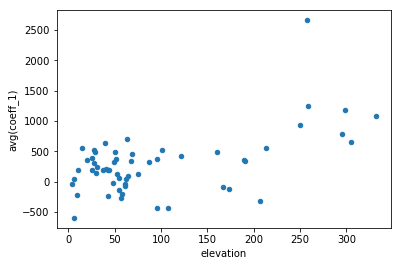

In [11]:
%matplotlib inline
pdf.plot.scatter(x='elevation',y='avg(coeff_1)');